# Pokemon Classification Using DenseNet201

## Data Loading

In [ ]:
# Downloading dataset via Kaggle

!kaggle datasets download -d lantian773030/pokemonclassification

Dataset URL: https://www.kaggle.com/datasets/lantian773030/pokemonclassification
License(s): copyright-authors
pokemonclassification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Extracting Data from Zipfile

import zipfile
zip_ref = zipfile.ZipFile('/content/pokemonclassification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Data Prepartaion

In [ ]:
# Importing Necessory Libraries

import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Creating Dataframe

def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

In [ ]:
# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# Split dataframe to train, valid, and test

def split_data(data_dir):

    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [ ]:
# Loading dataset

data_dir = '/content/PokemonData'

In [ ]:
# Spliting data into train, test and validation dataframe

train_df, valid_df, test_df = split_data(data_dir)

In [ ]:
# Data Augmentation

def create_gens(train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)


    ts_length = len(test_df)
    test_batch_size = max(
        sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

    test_steps = ts_length // test_batch_size

    def scalar(img):
        return img / 255.0

    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True,
        rotation_range=20,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )


    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Train Generator
    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # Validation Generator
    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # Test Generator
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=False,
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 5454 validated image filenames belonging to 150 classes.
Found 683 validated image filenames belonging to 150 classes.
Found 683 validated image filenames belonging to 150 classes.


## Data Visualization

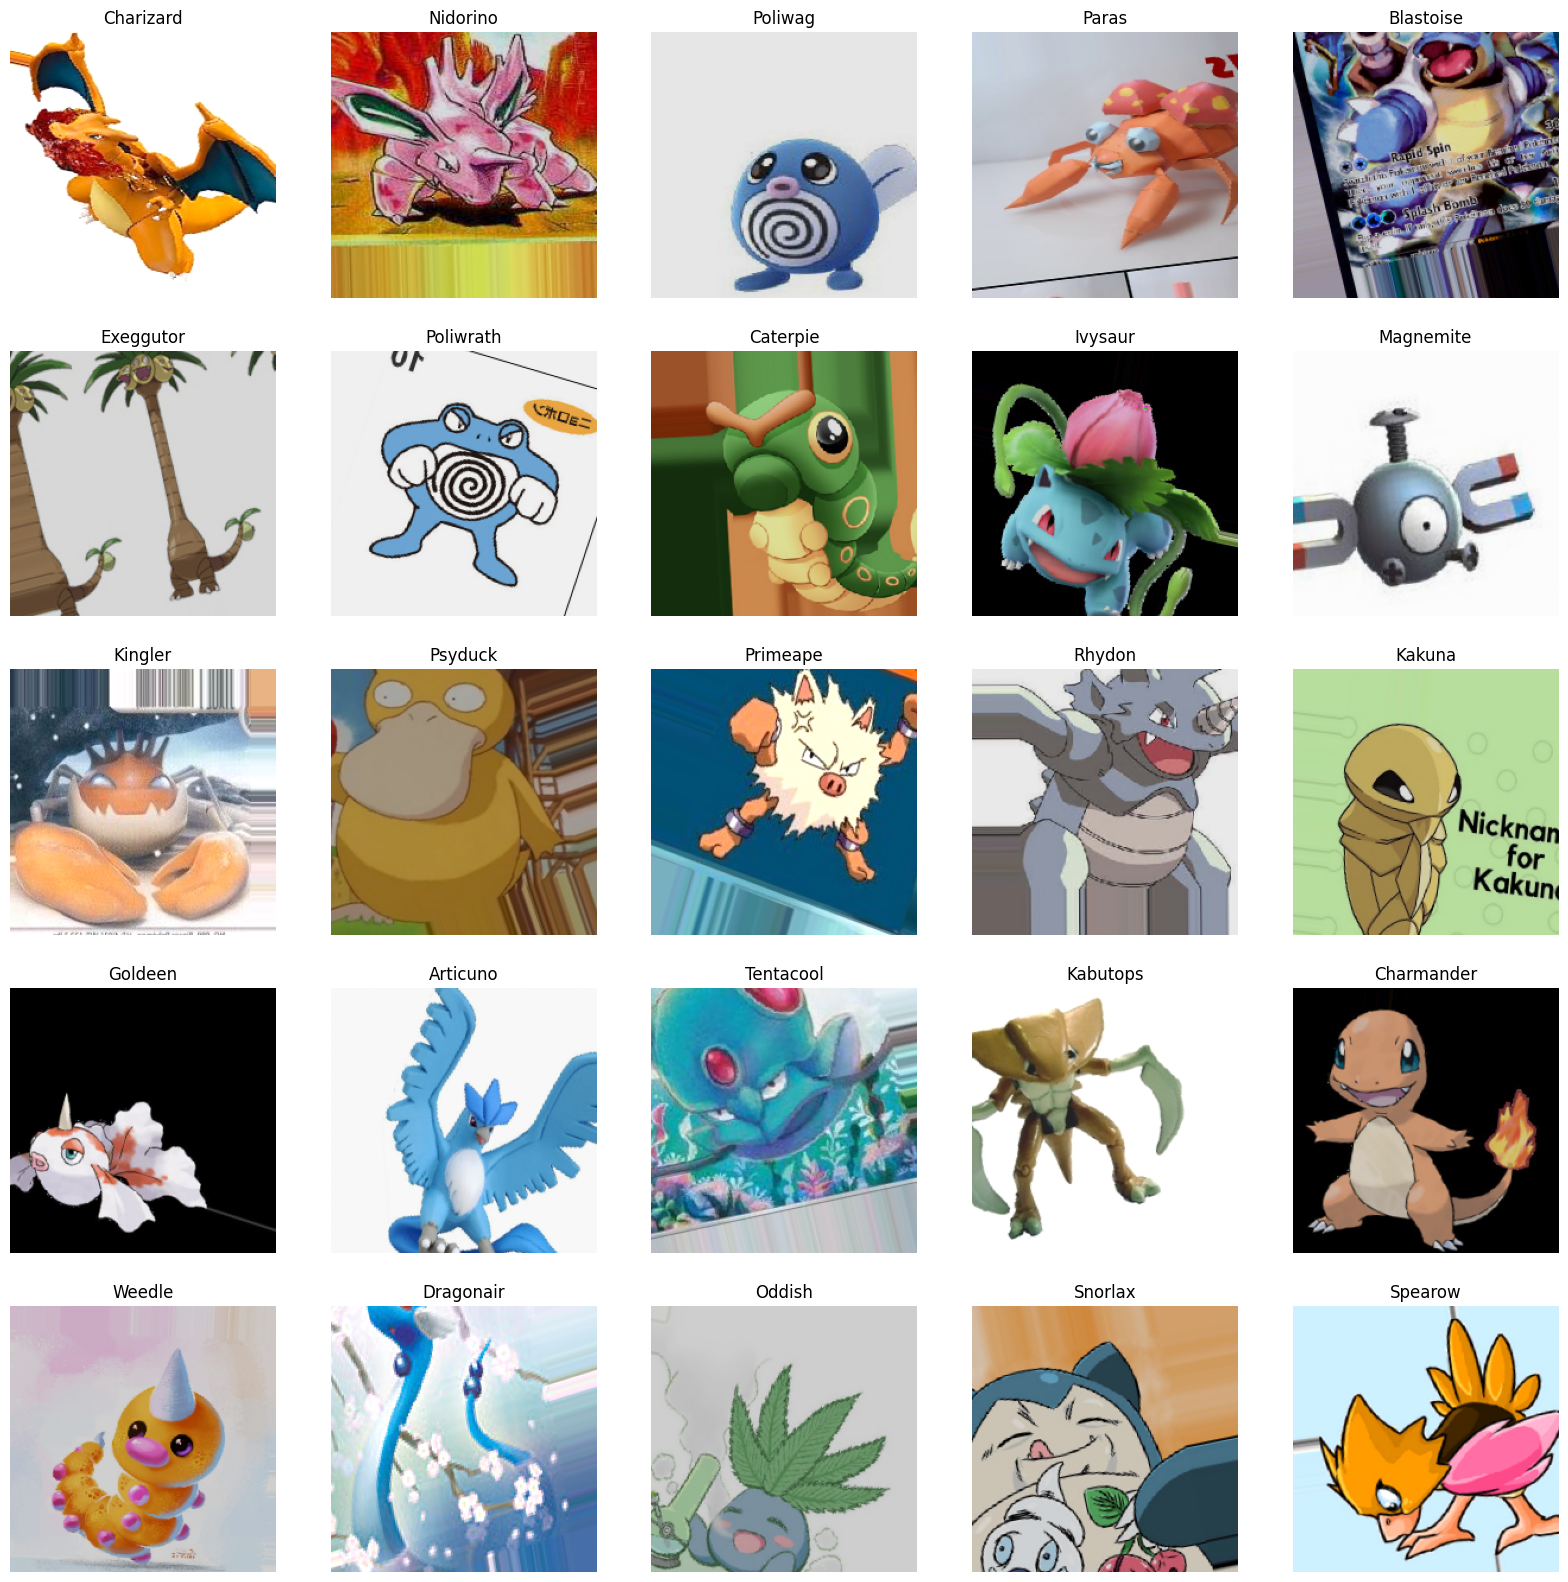

In [ ]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize=(20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)

        image = images[i]
        if image.shape[-1] == 1:
            plt.imshow(image.squeeze(), cmap='gray')
        else:
            plt.imshow(image)

        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='black', fontsize=12)
        plt.axis('off')

    plt.show()

show_images(train_gen)

## Model Building

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential

In [ ]:
img_size = 224

base_model = DenseNet201(include_top = False,
                         weights = 'imagenet',
                         input_shape = (img_size,img_size,3))

for layer in base_model.layers[:675]:
    layer.trainable = False

for layer in base_model.layers[675:]:
    layer.trainable = True

nb = len(train_gen.class_indices)


In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(nb, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │         288,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,610,134 (70.99 MB)

 Trainable params: 1,434,134 (5.47 MB)

 Non-trainable params: 17,176,000 (65.52 MB)

In [ ]:
hist = model.fit(train_gen, validation_data=valid_gen, epochs=30)

## Model Prediction

In [ ]:
history_df=pd.DataFrame(hist.history)
history_df

In [ ]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()